In [ ]:
%%capture
!pip install tokenizers transformers datasets 
!pip install wandb -qU

In [ ]:
%%capture
!pip install lightning-bolts==0.7.0

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from nltk.translate.bleu_score import corpus_bleu
from dataclasses import dataclass,asdict
from datasets import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
#from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.utils.data import DataLoader
from tqdm import tqdm 
from kaggle_secrets import UserSecretsClient
import wandb
import yaml
import random, torch, numpy as np

user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wbtok"))
# Choose the Kaggle API token JSON file that you downloaded
#files.upload()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


special_tokens = {'unk_token':"[UNK]",
                  'cls_token':"[CLS]",
                  'eos_token': '[EOS]',
                  'sep_token':"[SEP]",
                  'pad_token':"[PAD]",
                  'mask_token':"[MASK]",
                  'bos_token':"[BOS]"}
# Load tokenizers
source_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", **special_tokens)
target_tokenizer = PreTrainedTokenizerFast.from_pretrained('Sifal/EN2KAB',token=key=user_secrets.get_secret("hftoken"))

def addPreprocessing(tokenizer):
      tokenizer._tokenizer.post_processor = TemplateProcessing(
          single=tokenizer.bos_token + " $A " + tokenizer.eos_token,
          special_tokens=[(tokenizer.eos_token, tokenizer.eos_token_id), (tokenizer.bos_token, tokenizer.bos_token_id)])

addPreprocessing(source_tokenizer)
addPreprocessing(target_tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# Monolingual data
path = "/kaggle/input/en2kab/eng2kab.tsv"
#files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".txt")]
# Kabyle English pairs
df = pd.read_csv(path,sep='\t',names=['id1','en','id2','kab'], header=None).drop(columns=['id1','id2'])

In [6]:
def enforce_reproducibility(use_seed=None):
    seed = use_seed if use_seed is not None else random.randint(1, 1000000)
    print(f"Using seed: {seed}")

    random.seed(seed)    # python RNG
    np.random.seed(seed) # numpy RNG

    # pytorch RNGs
    torch.manual_seed(seed)          # cpu + cuda
    torch.cuda.manual_seed_all(seed) # multi-gpu - can be called without gpus
    if use_seed: # slower speed! https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark     = False

    return seed

In [7]:
## from dataclasses import dataclass
seed_ = enforce_reproducibility()

@dataclass
class Config:
    seed: int = seed_
    data_folder: str = "/kaggle/input/en2kab/"
    output_dir: str = './logs'
    src_max_length: int = 21
    tgt_max_length: int = 22
    add_special_tokens: bool = True
    truncation: bool = True
    return_tensors: str = 'pt'
    padding: str = True
    emb_size: int = 512
    source_vocab_size: int = 30524  # Initialize to 0 or provide the actual value
    target_vocab_size: int = 30000  # Initialize to 0 or provide the actual value
    num_encoder_layers: int = 5
    num_decoder_layers: int = 5
    nhead: int = 2
    ffn_hid_dim: int = 2048
    train_batch_size: int = 288
    eval_batch_size: int = 256
    learning_rate: float = 1e-4
    warmup_start: float = 1e-4
    scheduler: str = 'LinearWarmupCosineAnnealingLR'
    num_train_epochs: int = 30
    warmup_epochs: int = 15
    label_smoothing : float = 0.2

run_num = 15
config = Config()

Using seed: 429621


In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="EN2KAB", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VanillaTransoformer_{run_num}", 
      # Track hyperparameters and run metadata
      config=asdict(config))

In [ ]:
wandb.finish()

In [ ]:
class kabeng():
    def __init__(self, part, path):
        
        assert part in ('train','test'), ValueError("Invalid value for part, please choose train or test")
        
        df = pd.read_csv("/kaggle/input/en2kab/"+'eng2kab.tsv',sep='\t',names=['id1','en','id2','kab'], header=None).drop(columns=['id1','id2'])
        if part == 'train':
            df = df[:9*len(df)//10]
        else:
            df = df[9*len(df)//10:]
        self.data = df
        # create funtion to tokenize data
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        data = self.data.iloc[idx]
        return {'kab': data['kab'],
               'en': data['en']}

def get_dataset(part, path = "/kaggle/input/en2kab/"):
    return kabeng(part, path)

In [8]:
tokenizer_params = {"add_special_tokens": config.add_special_tokens,
                "truncation": config.truncation,
                "return_tensors": config.return_tensors,
                "padding": config.padding}

def collate(batch):
    
    en = source_tokenizer([item['en'] for item in batch],**tokenizer_params,max_length = config.src_max_length)
    kab = target_tokenizer([item['kab'] for item in batch],**tokenizer_params, max_length = config.tgt_max_length)
    
    src_max_lenght = en['attention_mask'].size(1)
    tgt_max_lenght = kab['attention_mask'].size(1)

    source_mask = torch.zeros((src_max_lenght, src_max_lenght), dtype=torch.bool)
    target_mask = torch.tril(torch.full((tgt_max_lenght -1, tgt_max_lenght -1), float('-inf')), diagonal=-1).transpose(0, 1)
    
    return {
            'source_input_ids':en['input_ids'],
            'source_padding_mask': ~en['attention_mask'].type(torch.bool),
            'source_mask' : source_mask,
            'target_input_ids': kab['input_ids'],
            'target_padding_mask': ~kab['attention_mask'][:,:-1].type(torch.bool),
            'target_mask': target_mask
            }

In [9]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
transformer = Seq2SeqTransformer(config.num_encoder_layers, config.num_decoder_layers, config.emb_size,
                                 config.nhead, config.source_vocab_size, config.target_vocab_size, config.ffn_hid_dim)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    transformer = nn.DataParallel(transformer)

transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index= target_tokenizer.pad_token_id,label_smoothing = config.label_smoothing)

optimizer = torch.optim.Adam(transformer.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-8)

#scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_start_lr= config.warmup_start, warmup_epochs=config.warmup_epochs, max_epochs=config.num_train_epochs)



In [ ]:
# initialize the datasets
train = get_dataset('train')
test = get_dataset('test')

In [ ]:
train_dataloader = DataLoader(train, batch_size=config.train_batch_size,collate_fn=collate,num_workers=2,shuffle=True)
val_dataloader = DataLoader(test, batch_size=config.train_batch_size,collate_fn=collate,num_workers=2)

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for batch in tqdm(train_dataloader,desc='train'):
        
        source_input_ids = batch['source_input_ids'].to(device)
        source_padding_mask = batch['source_padding_mask'].to(device)
        source_mask = batch['source_mask'].repeat(torch.cuda.device_count(), 1).to(device)
        
        target_input_ids = batch['target_input_ids'].to(device)
        target_padding_mask = batch['target_padding_mask'].to(device)
        target_mask = batch['target_mask'].repeat(torch.cuda.device_count(), 1).to(device)

        target_input_ids_ = target_input_ids[:, :-1]

        logits = model(source_input_ids, target_input_ids_, source_mask, target_mask,source_padding_mask, target_padding_mask, source_padding_mask)

        optimizer.zero_grad()
        _target_input_ids = target_input_ids[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), _target_input_ids.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    for batch in tqdm(val_dataloader,desc='evaluation'):

        source_input_ids = batch['source_input_ids'].to(device)
        source_padding_mask = batch['source_padding_mask'].to(device)
        source_mask = batch['source_mask'].repeat(torch.cuda.device_count(), 1).to(device)
        
        target_input_ids = batch['target_input_ids'].to(device)
        target_padding_mask = batch['target_padding_mask'].to(device)
        target_mask = batch['target_mask'].repeat(torch.cuda.device_count(), 1).to(device)

        target_input_ids_ = target_input_ids[:, :-1]

        logits = model(source_input_ids, target_input_ids_, source_mask, target_mask,source_padding_mask, target_padding_mask, source_padding_mask)

        optimizer.zero_grad()
        _target_input_ids = target_input_ids[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), _target_input_ids.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [10]:
model_checkpoint_dir = 'model_checkpoints'
os.makedirs(model_checkpoint_dir, exist_ok=True)

config_checkpoint_dir = 'configs'
os.makedirs(config_checkpoint_dir, exist_ok=True)
def save_config(runum= None):
    runum = run_num if run_num is None else runum
    # Create a dictionary to store the parameters
    model_params = {
        "num_encoder_layers": config.num_encoder_layers,
        "num_decoder_layers": config.num_decoder_layers,
        "emb_size": config.emb_size,
        "nhead": config.nhead,
        "source_vocab_size": config.source_vocab_size,
        "target_vocab_size": config.target_vocab_size,
        "ffn_hid_dim": config.ffn_hid_dim
    }

    # Save the parameters to a YAML file (e.g., 'model_config.yaml')
    with open(f'{config_checkpoint_dir}/model_config_run_{run_num}.yaml', 'w') as yaml_file:
        yaml.dump(model_params, yaml_file)

    
def load_checkpoint(run, model_checkpoint_dir='/kaggle/working/model_checkpoints',config_dir='/kaggle/working/configs', optimizer=None):
    
    with open(f'{config_dir}/model_config_run_{run}.yaml', 'r') as yaml_file:
        loaded_model_params = yaml.safe_load(yaml_file)

    # Create a new instance of the model with the loaded configuration
    loaded_transformer = Seq2SeqTransformer(
        loaded_model_params["num_encoder_layers"],
        loaded_model_params["num_decoder_layers"],
        loaded_model_params["emb_size"],
        loaded_model_params["nhead"],
        loaded_model_params["source_vocab_size"],
        loaded_model_params["target_vocab_size"],
        loaded_model_params["ffn_hid_dim"]
    )
    
    checkpoint = torch.load(f'{model_checkpoint_dir}/best_checkpoint_run_{run}.pt')
    
        # Remove the "module." prefix from parameter names caused by trained with ddp
    new_state_dict = {}
    for key, value in checkpoint['model_state_dict'].items():
        if key.startswith('module.'):
            new_key = key[7:]  # Remove the "module." prefix
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value

    loaded_transformer.load_state_dict(new_state_dict)
    #if optimizer:
      #  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['best_val_loss']
    return loaded_transformer,epoch, loss

In [ ]:
save_config()

In [2]:
best_val_loss = float('inf')  # Initialize with a large value
current_patience = 0  # Initialize patience counter
threshold = 0.01  # Set your desired threshold for loss improvement
checkpoint_patience = 8

def save_checkpoint(epoch, model, optimizer, val_loss = float('inf'), force = False,):
    global best_val_loss, current_patience
    if force | (val_loss < (best_val_loss - threshold)):
        best_val_loss = val_loss
        current_patience = 0  # Reset patience counter
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }
        model_checkpoint_path = os.path.join(model_checkpoint_dir, f'best_checkpoint_run_{run_num}.pt')
        torch.save(checkpoint, model_checkpoint_path)
        print(f"Checkpoint saved at {model_checkpoint_path}")
    else:
        current_patience += 1

    if current_patience >= checkpoint_patience:
        current_patience
        print(f"Validation loss hasn't improved for {current_patience} epochs. Stopping training.")
        exit()
    else:
        return False

In [ ]:
for epoch in range(1, config.num_train_epochs+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    #scheduler.step()
    if epoch > config.warmup_epochs:
        save_checkpoint(epoch, transformer, optimizer, val_loss)
    #wandb.log({"Epoch": epoch, "train_loss": train_loss,"val_loss":val_loss, "lr" : optimizer.param_groups[0]['lr']})
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

In [ ]:
wandb.finish()

In [ ]:
save_checkpoint(epoch,transformer.module,optimizer,force=True)

In [11]:
token_config = {
                "add_special_tokens": config.add_special_tokens,
                "return_tensors": config.return_tensors,
             }

In [12]:
# Function to generate an output sequence using the greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    # Move inputs to the device
    src = src.to(device)
    src_mask = src_mask.to(device)

    # Encode the source sequence
    memory = model.encode(src, src_mask)

    # Initialize the target sequence with the start symbol
    ys = torch.tensor([[start_symbol]]).type(torch.long).to(device)

    for i in range(max_len - 1):
        memory = memory.to(device)

        # Create a target mask for autoregressive decoding
        tgt_mask = torch.tril(torch.full((ys.size(1), ys.size(1)), float('-inf'), device=device), diagonal=-1).transpose(0, 1).to(device)
        # Decode the target sequence
        out = model.decode(ys, memory, tgt_mask)
        # Generate the probability distribution over the vocabulary
        prob = model.generator(out[:, -1])

        # Select the next word with the highest probability
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        # Append the next word to the target sequence
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)

        # Check if the generated word is the end-of-sequence token
        if next_word == target_tokenizer.eos_token_id:
            break

    return ys

# Actual function to translate input sentence into the target language
def translate(model: torch.nn.Module , src_sentence: str, raw: bool = False):
    model.to(device)
    model.eval()
    # Tokenize the source sentence
    src = source_tokenizer(src_sentence, **token_config)['input_ids']
    num_tokens = src.shape[1]
    # Create a source mask
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    # Generate the target tokens using greedy decoding
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 5, start_symbol=target_tokenizer.bos_token_id).flatten()
    
    # Decode the target tokens and clean up the result
    if raw:
        return tgt_tokens.tolist()
    return target_tokenizer.decode(tgt_tokens, clean_up_tokenization_spaces=True, skip_special_tokens=True)


In [13]:
# Beam Search implementation
def beam_search_decode(model, src, src_mask, max_len, start_symbol, beam_size=5):
    # Move inputs to the device
    src = src.to(device)
    src_mask = src_mask.to(device)


    # Encode the source sequence
    memory = model.encode(src, src_mask)

    # Initialize the beams (sequences, score)
    beams = [(torch.tensor([[start_symbol]]).type(torch.long).to(device), 0)]

    for i in range(max_len - 1):
        new_beams = []

        for ys, score in beams:
            # Create a target mask for autoregressive decoding
            tgt_mask = torch.tril(torch.full((ys.size(1), ys.size(1)), float('-inf'), device=device), diagonal=-1).transpose(0, 1).to(device)
            # Decode the target sequence
            out = model.decode(ys, memory, tgt_mask)
            # Generate the probability distribution over the vocabulary
            prob = model.generator(out[:, -1])

            # Get the top beam_size candidates for the next word
            _, top_indices = torch.topk(prob, beam_size, dim=1)
            for i,next_word in enumerate(top_indices[0]):
                next_word = next_word.item()
                if next_word == target_tokenizer.eos_token_id:
                    continue

                # Append the next word to the target sequence
                new_ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
                new_score = score + prob[0][next_word].item()

                # Check if the generated word is the end-of-sequence token
                if next_word == target_tokenizer.eos_token_id:
                    new_beams.append((new_ys, new_score))
                else:
                    new_beams.append((new_ys, new_score))

        # Sort the beams by score and select the top beam_size beams
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    # Return the best beam
    best_beam = beams[0][0]
    return best_beam


# Actual function to translate input sentence into the target language using beam search
def translate_with_beam_search(model: torch.nn.Module, src_sentence: str, beam_size=5, raw: bool = False):
    model.to(device)
    model.eval()
    # Tokenize the source sentence
    src = source_tokenizer(src_sentence, **token_config)['input_ids']
    num_tokens = src.shape[1]
    # Create a source mask
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    # Generate the target tokens using beam search decoding
    tgt_tokens = beam_search_decode(
        model, src, src_mask, max_len=num_tokens + 6, start_symbol=target_tokenizer.bos_token_id, beam_size=beam_size).flatten()
    if raw:
        return tgt_tokens
    # Decode the target tokens and clean up the result
    return target_tokenizer.decode(tgt_tokens, clean_up_tokenization_spaces=True, skip_special_tokens=True)


In [22]:
model,_,__ = load_checkpoint(run=15)

In [15]:
story = '''One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt. Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt." Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'''.split('.')

In [29]:
for s in story:
    print('sentence: ',s,'\ntranlsation: ', translate_with_beam_search(model,s,beam_size=4))

sentence:  One day, a little girl named Lily found a needle in her room 
tranlsation:  I wet yiwet n tek liz ya, ɣef yiwet n tek riṭ ij, yiwet n tek liz ya ẓ
sentence:   She knew it was difficult to play with it because it was sharp 
tranlsation:  Yew ɛer ad tε elmeḍ imi tet teddu ad turar ɣer wurar - nni imi tella tetturar yid - s
sentence:   Lily wanted to share the needle with her mom, so she could sew a button on her shirt 
tranlsation:  Yella tebɣa ad sb egg in egg net ɣer tqeff alt n yemma - s, tebɣa kan ad tneɣ ṛit yeččuṛen d tqeff alin - is
sentence:   Lily went to her mom and said, "Mom, I found this needle 
tranlsation:  Ɣef yemma - s, in ebb ec leɣ, ǧǧiɣ yemma - s, ǧǧiɣ yemma - s! Taggara,
sentence:   Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt 
tranlsation:  Yer fed yemma - k, tzemreḍ ad twaliḍ taṛ egg elt - iw? " W wet - nni yes tull sen, ne ţţ u ad yesfer ḍ egg nen s ", ini - as akked jeddi -


In [18]:
# It takes long to compute the BLEU Score

def bleu_score(model, src,tgt):
    # Get the bleu score of a model
    actual, predicted = [], []
    for source,target in zip(src,tgt):
        # translate encoded source text
        translation = translate(model,source,raw=True)
        translation = target_tokenizer.convert_ids_to_tokens(translation,skip_special_tokens=True)
        target = target_tokenizer.tokenize(target)
        actual.append(target)
        predicted.append(translation)
        
    bleu = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu

In [ ]:
e,k = df['en'][:71541],df['kab'][:71541],
bleu_train = bleu_score(model, src= e, tgt=k)
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


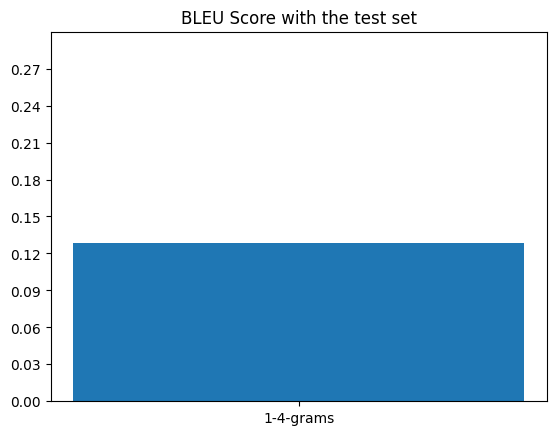

In [19]:
e2,k2 = df['en'][71541:],df['kab'][71541:]
bleu_test = bleu_score(model, src= e2, tgt=k2)
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,0.3))
yticks = np.arange(0,0.3, 0.03)
plt.yticks(yticks)
plt.show()

In [24]:
bleu_test

{'1-4-grams': 0.12817481122803195}